In [1]:
# !pip install lava-nc
# !pip install networkx==2.8
# !pip install matplotlib
# !pip install cvxpy
# !pip install lava-nc
# !pip install pandas

In [2]:
# import lava
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cProfile

In [3]:
def graph_to_mat(G, path = 'test_graphs/default2.mat'):
    # get the adjancency matrix of the graph
    adj = nx.adjacency_matrix(G).todense()
    adj = np.asarray(adj, dtype=np.int32)
    scipy.io.savemat(path, {'M': adj})   # M for matrix, to stay consistent with the .mat files we already have
    return

def mat_to_graph(path):
    mat = scipy.io.loadmat(path)
    G = nx.from_numpy_array(mat['M'])
    return G

In [4]:
def gen_permutation_matrix(phi):
    n = phi.shape[0]
    order = np.argsort(phi)
    P = np.zeros((n, n))
    for i in range(n):
        P[i,order[i]] = 1  # orignally P[i,order[i]] = 1
    return P, order

def get_chr(P, A, order):
    n = A.shape[0]
    PAPT = (P @ A) @ P.T
    block_list = []
    color_blocks = []
    i = 0
    while (i<n):
        condition = 0
        block = 0
        color_block = []
        while (condition==0 and (i+block)<n):
            #if PAPT[i:i+block+1,i:i+block+1] == np.zeros((block+1,block+1)):
            if np.sum(np.abs(PAPT[i:i+block+1,i:i+block+1])) == 0:
                color_block.append(order[i+block])
                block = block+1
            else:
                condition = 1
        block_list.append(block)
        color_blocks.append(color_block)
        i = i + block
    return len(block_list), color_blocks

def get_color_indice_array(color_blocks, adj):
    color_indice_array = np.zeros(adj.shape[0], dtype=np.int32)
    temp_color_index = 0
    for color_block in color_blocks:
        for node in color_block:
            color_indice_array[node] = temp_color_index
        temp_color_index += 1
    num_colors = temp_color_index
    return color_indice_array, num_colors

def density(adj_matrix):
    return np.sum(adj_matrix) / (adj_matrix.shape[0] * (adj_matrix.shape[1]-1))

def get_color_adj_graph(color_indice_array, adj, num_colors):
    color_adj = np.zeros((num_colors,num_colors), dtype=np.int32)
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if adj[i][j] == 1:
                color_adj[color_indice_array[i]][color_indice_array[j]] = 1
    return color_adj

def loss(phi_history,adj):
    num_nodes = adj.shape[0]
    loss_list = []
    for i in range (len(phi_history)):
        curr_phi = phi_history[i]
        loss = 0
        for j in range (num_nodes):
            for k in range (j):
                if(adj[j][k] == 1):
                    loss -= 1 - np.cos(curr_phi[j] - curr_phi[k])
        loss_list.append(loss)
    return loss_list

def gen_cyclic_graph(n):
    B = np.zeros((n, n))
    for i in range(n):
        B[i,i-1] = 1.0
        B[i,(i+1)%n] = 1.0
    return B

In [5]:
phi_diff = [1,2,3]
phi_diff = np.array(phi_diff)
phi_diff = np.reshape(phi_diff, (3,))
print(phi_diff.shape)
x=phi_diff[:,None]-phi_diff
print(x.shape)

(3,)
(3, 3)


In [22]:
def graph_painter_tan_inv(adj, num_iters = 3, sigma_noise = 0, phi_init = None, step_size = 0.1):
    # phi is a row vector
    n = adj.shape[0]
    # phi = uniform randomly between -1 and 1
    if phi_init is None:
        curr_phi = np.random.uniform(-1, 1, n)*np.pi*0.5
    else:
        curr_phi = phi_init
    min_colors = n
    best_coloring = [[i] for i in range(n)]
    phi_history = []
    phi_history.append(curr_phi)
    for i in range(num_iters):
        # update phi
        curr_phi = curr_phi + sigma_noise*np.random.randn(n)
        curr_cos = np.cos(curr_phi)
        curr_sin = np.sin(curr_phi)

        cos_sum_term = adj @ curr_cos
        sin_sum_term = adj @ curr_sin

        curr_phi = np.arctan2(-sin_sum_term, -cos_sum_term)

        curr_phi[curr_phi > np.pi] = curr_phi[curr_phi > np.pi] - 2*np.pi
        curr_phi[curr_phi < -np.pi] = curr_phi[curr_phi < -np.pi] + 2*np.pi
        phi_history.append(curr_phi)
        P, order = gen_permutation_matrix(curr_phi)
        num_chr, color_blocks = get_chr(P, adj, order)
        if num_chr < min_colors:
            min_colors = num_chr
            best_coloring = color_blocks
        # convert phi_history to numpy array
    phi_history = np.array(phi_history)
    return min_colors, best_coloring, phi_history

Density of the original graph:  0.7857142857142857
Density of the colored graph:  1.0
Num Colors:  5
[[0], [1], [2], [3], [4, 5, 6, 7]]
[0.05914802 0.         0.06207766 0.00020457 0.1407819  0.1407819
 0.1407819  0.1407819 ]


/tmp/ipykernel_4455/4119681454.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()
/tmp/ipykernel_4455/4119681454.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()
/tmp/ipykernel_4455/4119681454.py:21: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()
/tmp/ipykernel_4455/4119681454.py:31: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


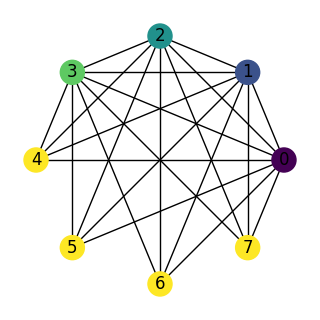

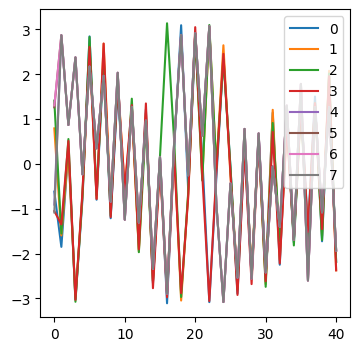

(41, 8)


In [42]:
# read myciel4 graph
# G = mat_to_graph('test_graphs/dsjc125.5.mat')
# G = complete graph with 3 nodes

n = 5
# # craete a complete graph
G = nx.complete_graph(n)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
# add a new node
G.add_node(n)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
for i in range(n-1):
    G.add_edge(i, n)
    G.add_edge(n, i)
    adj[i][n] = 1
    adj[n][i] = 1

G.add_node(n+1)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
for i in range(n-1):
    G.add_edge(i, n+1)
    G.add_edge(n+1, i)
    adj[i][n+1] = 1
    adj[n+1][i] = 1

G.add_node(n+2)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
for i in range(n-1):
    G.add_edge(i, n+2)
    G.add_edge(n+2, i)
    adj[i][n+2] = 1
    adj[n+2][i] = 1

# adj = gen_cyclic_graph(17)
# G = nx.from_numpy_array(adj)

density_original = density(adj)
print("Density of the original graph: ", density_original)
num_colors, coloring, phi_history = graph_painter_tan_inv(adj, num_iters=40, sigma_noise=1, step_size=0.1)
# num_colors, coloring, phi_history = graph_painter_exp_color_based_exp(adj, num_iters=4000, sigma_noise=0, step_size=0.1, central_term_only=False)
color_indice_array, _ = get_color_indice_array(coloring, adj)
density_colored = density(get_color_adj_graph(color_indice_array, adj, num_colors))
print("Density of the colored graph: ", density_colored)
print("Num Colors: ", num_colors)
print(coloring)
print((np.asarray(phi_history[-1])-np.min(np.asarray(phi_history[-1])))/np.pi)

# Plot the graph with the coloring
plt.figure(figsize=(3, 3))
nx.draw_circular(G, with_labels=True, node_color=color_indice_array)
plt.show()

# plot the phi history row wise
plt.figure(figsize=(4,4))
plt.plot(phi_history)
plt.legend([i for i in range(adj.shape[0])])
plt.show()

print(phi_history.shape)

In [49]:
graph_name = 'dsjc250.5'
G = mat_to_graph('test_graphs/'+graph_name+'.mat')
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
density_original = density(adj)


# num_colors, coloring, phi_history = graph_painter_exp_color_based_exp(adj, num_iters=4000, sigma_noise=0.07, step_size=0.1, central_term_only=False)
num_colors, coloring, phi_history = graph_painter_tan_inv(adj, num_iters=1000, sigma_noise=0.5)
color_indice_array, _ = get_color_indice_array(coloring, adj)
density_colored = density(get_color_adj_graph(color_indice_array, adj, num_colors))
print("Density of the colored graph: ", density_colored)
print("Num Colors: ", num_colors)

/tmp/ipykernel_4455/952423192.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


Density of the colored graph:  0.8260467268100856
Num Colors:  132


In [36]:
phi_history[-1]

array([-0.02400034, -0.01979177,  0.00322582, -0.01804458, -0.02497292,
       -0.01014345, -0.01560723, -0.01963637, -0.00142874, -0.02043663,
       -0.00674443, -0.00375413, -0.01126209, -0.01439892, -0.00277403,
       -0.0160481 ,  0.00411083, -0.01511087, -0.0073945 , -0.0148327 ,
       -0.02216282, -0.00982845, -0.01327299, -0.01972891, -0.014315  ,
       -0.02438243, -0.0127305 , -0.03470756, -0.01853802, -0.01711158,
        0.00417142, -0.00595223, -0.01166783, -0.01162655, -0.02074933,
       -0.00819344, -0.01061785, -0.03768553, -0.0153593 , -0.01536839,
       -0.01693651, -0.02997425,  0.00280966, -0.00275887, -0.0117377 ,
       -0.01633855, -0.01322005, -0.01252886, -0.01264482, -0.00304747,
       -0.01899444, -0.02220533, -0.02036817, -0.00233029, -0.02240374,
       -0.0103537 , -0.00732345, -0.0179569 ,  0.0061395 , -0.02078816,
       -0.01366875,  0.00519594,  0.00226769, -0.0193205 , -0.00382901,
       -0.02686491,  0.0093476 , -0.00794819, -0.02146306, -0.01

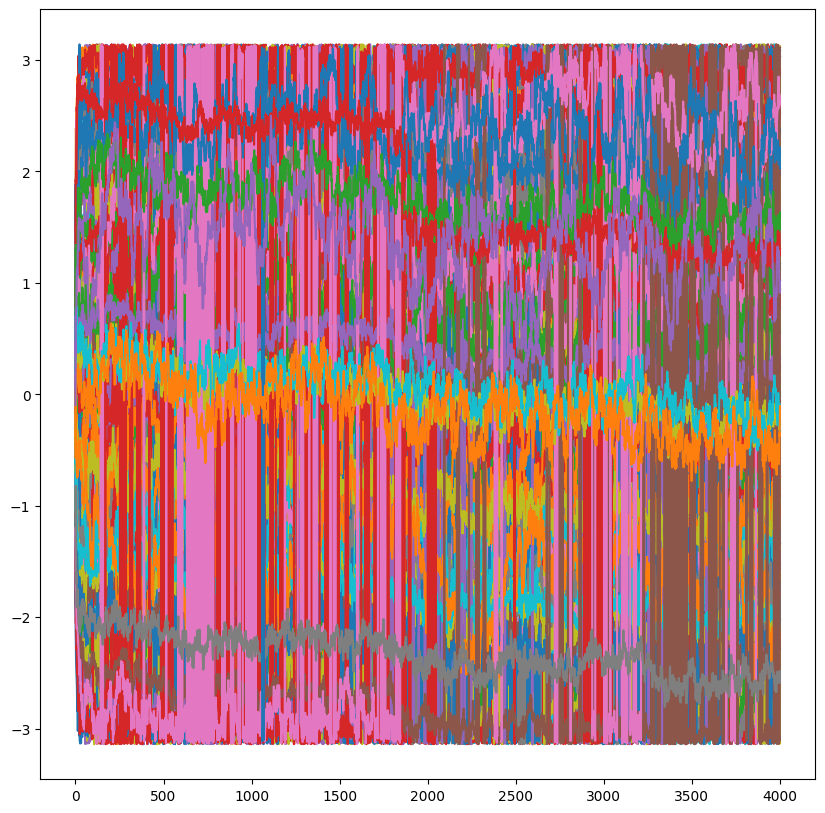

In [57]:
# Plot phi history
plt.figure(figsize=(10,10))
plt.plot(phi_history)
# plt.legend([i for i in range(adj.shape[0])])
plt.show()

In [ ]:

graph_names_large = ['dsjc125.1', 'dsjc125.5', 'dsjc250.5', 'dsjc500.1', 'dsjc500.5', 'dsjc500.9']
num_runs = 5
num_colors_graph_painter2 = []
num_colors_graph_painter2_scaled = []
num_colors_graph_painter_basic = []
num_colors_random_ordering = []
density_list = []
num_nodes_list = []

for graph_name in graph_names_large:
    G = mat_to_graph('test_graphs/'+graph_name+'.mat')
    adj = nx.adjacency_matrix(G).toarray()
    adj = np.asarray(adj, dtype=np.int32)
    num_colors_list_graph_painter2 = []
    num_colors_list_graph_painter2_scaled = []
    num_colors_list_graph_painter_basic = []
    num_colors_list_random_ordering = []
    print("Graph: ", graph_name)
    density_temp = density(adj)
    # Trim density to 4 decimal places
    density_temp = float("{:.4f}".format
                         (density_temp))
    density_list.append(density_temp)
    num_nodes_list.append(adj.shape[0])
    print("Density of the graph: ", density_temp)
    print()
    for i in range(num_runs):
        num_colors, _, _ = graph_painter2(adj, num_iters = 2000, sigma_noise = 0.0, step_size = 0.01)
        num_colors_list_graph_painter2.append(num_colors)

        num_colors, _, _ = graph_painter2_scaled(adj, num_iters = 2000, sigma_noise = 0.0, step_size = 0.01)
        num_colors_list_graph_painter2_scaled.append(num_colors)

        color_blocks, _, _ = graph_painter_basic(adj)
        num_colors = len(color_blocks)
        num_colors_list_graph_painter_basic.append(num_colors)

        random_phases = np.random.uniform(-np.pi, np.pi, adj.shape[0])
        P, order = gen_permutation_matrix(random_phases)
        num_chr, color_blocks = get_chr(P, adj, order)
        if num_chr != len(color_blocks):
            print("ERROR IN RANDOM ORDERING")
        num_colors_list_random_ordering.append(num_chr)

    num_colors_graph_painter2.append(num_colors_list_graph_painter2)
    num_colors_graph_painter2_scaled.append(num_colors_list_graph_painter2_scaled)
    num_colors_graph_painter_basic.append(num_colors_list_graph_painter_basic)
    num_colors_random_ordering.append(num_colors_list_random_ordering)

num_colors_random_ordering = np.array(num_colors_random_ordering)
# Make a box plot for each graph with all the methods
for i in range(len(graph_names_large)):
    plt.figure(figsize=(6,4))
    plt.boxplot([num_colors_graph_painter2[i], num_colors_graph_painter2_scaled[i], num_colors_graph_painter_basic[i]], labels=['Graph painter2', 'Graph painter2 Scaled', 'Graph Painter Basic'])
    plt.title(graph_names_large[i] + ', Density = ' + str(density_list[i]) + ', Num Nodes = ' + str(num_nodes_list[i]))
    plt.show()
    print("Average Random Ordering: ", np.mean(num_colors_random_ordering[i]))
    print()